In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# when CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment
# https://stackoverflow.com/a/73992912

In [2]:
# essential packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split

# python modules
import matplotlib.pyplot as plt
import glob
import yaml
import numpy as np
import pandas as pd
import random

# custom module
from aux_code.learning_preprocess import convert_from_NED_to_Robotic, get_trajectory_before_pass, check_dimension

In [3]:
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

## Data Loader

In [4]:
file_name = "aisdk_20180101"
howmany=200
using_file_indices = np.arange(0,howmany)

In [5]:
df_entire_pass = pd.DataFrame()

# https://www.w3resource.com/pandas/dataframe/dataframe-to_pickle.php
for using_file_idx in using_file_indices:
    unpickled_df = pd.read_pickle("./dk_csv_20180101/binary/aisdk_20180101_{}.pkl".format(str(using_file_idx)))
    unpickled_df
    df_entire_pass = pd.concat([df_entire_pass, unpickled_df])

In [6]:
df_entire_pass

,x,y,v_x,v_y,rel_dist,rel_bearing,rel_bearing_diff,Heading,valid,obj_index,label
Timestamp,,,,,,,,,,,
2018-01-01 23:34:30,4.214136,2.391927,-0.009386,-0.006086,4.845643,0.516252,-0.001975,145.0,True,0,L
2018-01-01 23:34:45,4.086469,2.312937,-0.008511,-0.005266,4.695626,0.515043,-0.001209,145.5,True,0,L
2018-01-01 23:35:00,3.972708,2.235017,-0.007584,-0.005195,4.558257,0.512460,-0.002584,147.0,True,0,L
2018-01-01 23:35:15,3.857949,2.154808,-0.007651,-0.005347,4.418933,0.509374,-0.003086,150.5,True,0,L
2018-01-01 23:35:30,3.730337,2.078144,-0.008507,-0.005111,4.270140,0.508272,-0.001102,150.0,True,0,L
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 11:37:00,-0.388895,0.516592,-0.002982,0.003150,0.646611,2.216093,0.012567,235.0,True,199,L
2018-01-01 11:37:15,-0.433163,0.564382,-0.002951,0.003186,0.711447,2.225403,0.009310,235.0,True,199,L
2018-01-01 11:37:30,-0.475801,0.610369,-0.002843,0.003066,0.773910,2.232930,0.007527,234.0,True,199,L


### pre-processing

In [7]:
df_entire_pass['heading_converted']  = np.deg2rad(df_entire_pass['Heading'])
# lambda function method: very fast! 
# https://stackoverflow.com/questions/71249186/applying-function-to-column-in-a-dataframe
df_entire_pass['heading_converted'] = df_entire_pass['heading_converted'].apply(convert_from_NED_to_Robotic)


In [8]:
df_entire_pass

,x,y,v_x,v_y,rel_dist,rel_bearing,rel_bearing_diff,Heading,valid,obj_index,label,heading_converted
Timestamp,,,,,,,,,,,,
2018-01-01 23:34:30,4.214136,2.391927,-0.009386,-0.006086,4.845643,0.516252,-0.001975,145.0,True,0,L,-0.959931
2018-01-01 23:34:45,4.086469,2.312937,-0.008511,-0.005266,4.695626,0.515043,-0.001209,145.5,True,0,L,-0.968658
2018-01-01 23:35:00,3.972708,2.235017,-0.007584,-0.005195,4.558257,0.512460,-0.002584,147.0,True,0,L,-0.994838
2018-01-01 23:35:15,3.857949,2.154808,-0.007651,-0.005347,4.418933,0.509374,-0.003086,150.5,True,0,L,-1.055924
2018-01-01 23:35:30,3.730337,2.078144,-0.008507,-0.005111,4.270140,0.508272,-0.001102,150.0,True,0,L,-1.047198
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 11:37:00,-0.388895,0.516592,-0.002982,0.003150,0.646611,2.216093,0.012567,235.0,True,199,L,-2.530727
2018-01-01 11:37:15,-0.433163,0.564382,-0.002951,0.003186,0.711447,2.225403,0.009310,235.0,True,199,L,-2.530727
2018-01-01 11:37:30,-0.475801,0.610369,-0.002843,0.003066,0.773910,2.232930,0.007527,234.0,True,199,L,-2.513274


## Train, test data split

In [9]:
# https://www.geeksforgeeks.org/how-to-randomly-select-elements-of-an-array-with-numpy-in-python/

np.random.seed(0) # right now for consistent data testing


# for train, test data
use_df = df_entire_pass.loc[(df_entire_pass.valid == True)] # to be used, valid df
unique_id = use_df.obj_index.unique()

# data split
train_data_size = int(len(unique_id) * 0.8)
test_data_size = len(unique_id) - train_data_size
print("train size: {} \n test size: {}".format(train_data_size, test_data_size))

# split obj indexes
train_obj_id = np.random.choice(unique_id, size = train_data_size, replace=False)
test_obj_id = np.setdiff1d(unique_id, train_obj_id)
train_obj_id

train size: 160 
 test size: 40


array([ 18, 170, 107,  98, 177, 182,   5, 146,  12, 152,  61, 125, 180,
       154,  80,   7,  33, 130,  37,  74, 183, 145,  45, 159,  60, 123,
       179, 185, 122,  44,  16,  55, 150, 111,  22, 189, 129,   4,  83,
       106, 134,  66,  26, 113, 168,  63,   8,  75, 118, 143,  71, 124,
       184,  97, 149,  24,  30, 160,  40,  56, 131,  96, 181,  19, 153,
        92,  54, 163,  51,  86, 139,  90, 137, 101, 144,  89, 109,  14,
        27, 141, 187,  46, 138, 195, 108,  62,   2,  59, 136, 197,  43,
        10, 194,  73, 196, 178, 175, 126,  93, 112, 158, 191,  50,   0,
        94, 110,  95,  64, 167,  41,  69,  49,  48,  85,  13, 161,  23,
       186, 135,  20,  15,  78, 104,  52, 100,  76,   3, 116, 164, 198,
         6,  68,  84, 121, 155, 171, 156,  91, 199,  11, 119, 102,  35,
        57,  65,   1, 120, 162,  42, 105, 132, 173,  17,  38, 133,  53,
       157, 128,  34,  28])

In [10]:
# train data
df_cropped_train = get_trajectory_before_pass(df_entire_pass, train_obj_id)
df_cropped_train

,x,y,v_x,v_y,rel_dist,rel_bearing,rel_bearing_diff,Heading,valid,obj_index,label,heading_converted
0,4.132110,-2.747226,-0.005239,0.002781,4.962014,-0.586743,-0.001738,229.000000,True,18,L,-2.426008
1,4.047040,-2.700071,-0.005671,0.003144,4.865071,-0.588352,-0.001610,228.833333,True,18,L,-2.423099
2,3.965174,-2.653981,-0.005458,0.003073,4.771396,-0.589839,-0.001487,228.666667,True,18,L,-2.420190
3,3.859062,-2.608618,-0.007074,0.003024,4.658030,-0.594417,-0.004578,228.500000,True,18,L,-2.417281
4,3.772702,-2.562771,-0.005757,0.003056,4.560820,-0.596693,-0.002276,228.333333,True,18,L,-2.414372
...,...,...,...,...,...,...,...,...,...,...,...,...
32650,0.284465,-0.223252,-0.003810,0.004204,0.361609,-0.665412,0.032140,232.846154,True,28,L,-2.493136
32651,0.227320,-0.160196,-0.003810,0.004204,0.278096,-0.613884,0.051528,233.538462,True,28,L,-2.505219
32652,0.170175,-0.097141,-0.003810,0.004204,0.195949,-0.518692,0.095192,234.230769,True,28,L,-2.517302
32653,0.113031,-0.034085,-0.003810,0.004204,0.118058,-0.292885,0.225808,234.923077,True,28,L,-2.529385


In [11]:
np.all(df_cropped_train['label'])

True

In [12]:
np.any(np.isnan(df_cropped_train['y']))

False

In [13]:
# df_cropped_train = df_cropped_train[df_cropped_train['Heading_by_xy'].notna()]  # drop na for Heaing_by_xy
# np.any(np.isnan(df_cropped_train['Heading_by_xy']))

In [14]:
# test data
df_cropped_test = get_trajectory_before_pass(df_entire_pass, test_obj_id)
df_cropped_test

,x,y,v_x,v_y,rel_dist,rel_bearing,rel_bearing_diff,Heading,valid,obj_index,label,heading_converted
0,0.531333,4.889139,0.000172,-0.007141,4.917926,1.462545,-0.002815,90.6250,True,9,R,-0.010908
1,0.531943,4.777563,0.000041,-0.007438,4.807085,1.459911,-0.002634,90.9375,True,9,R,-0.016362
2,0.531469,4.642245,-0.000032,-0.009021,4.672568,1.456807,-0.003104,91.2500,True,9,R,-0.021817
3,0.534526,4.534370,0.000204,-0.007192,4.565767,1.453455,-0.003353,91.5625,True,9,R,-0.027271
4,0.537584,4.426495,0.000204,-0.007192,4.459020,1.449941,-0.003513,91.8750,True,9,R,-0.032725
...,...,...,...,...,...,...,...,...,...,...,...,...
12287,0.684961,0.278331,-0.010316,0.003894,0.739351,0.385965,0.129815,209.5000,True,193,L,-2.085668
12288,0.501735,0.356633,-0.012215,0.005220,0.615569,0.617937,0.231972,210.0000,True,193,L,-2.094395
12289,0.350640,0.416676,-0.010073,0.004003,0.544581,0.871248,0.253311,210.0000,True,193,L,-2.094395
12290,0.218809,0.477479,-0.008789,0.004053,0.525227,1.141095,0.269848,209.5000,True,193,L,-2.085668


In [15]:
# df_cropped_test = df_cropped_test[df_cropped_test['Heading_by_xy'].notna()] # drop na for Heaing_by_xy
# np.any(np.isnan(df_cropped_test['Heading_by_xy']))

## Train, test data onehot encoding and extract specific cell

In [16]:
# columns to extract
columns_for_x = ['x', 'y', 'rel_dist', 'rel_bearing', 'heading_converted']
# columns_for_x = ['x', 'y', 'v_x', 'v_y', 'rel_dist', 'rel_bearing', 'heading_converted']
# columns_for_x = ['r_value', 'atan']
columns_for_y = ['label']
binary_classification = True

# one hot encoding for y target
one_hot_lookup = torch.eye(2).tolist()

# df to array
X_train = []
X_test = []
y_train = []
y_test = []


#### train dataset
for obj_id, df_by_ID in df_cropped_train.groupby('obj_index'):
    X_train.append(df_by_ID[columns_for_x].values.tolist())

    if binary_classification:
        # y_train.append(one_hot_lookup[0] if df_by_ID[columns_for_y].values[-1][0] == "L" else one_hot_lookup[1]) # last row, only char
        y_train.append(0 if df_by_ID[columns_for_y].values[-1][0] == "L" else 1) # last row, only char
    else:
        # print(df_by_ID['bow_crossing'].values[-1] )
        y_train.append(0 if df_by_ID[columns_for_y].values[-1][0] == "L" and df_by_ID['bow_crossing'].values[-1] == True\
                       else 1 if df_by_ID[columns_for_y].values[-1][0] == "L" and df_by_ID['bow_crossing'].values[-1] ==  False\
                       else 2 if df_by_ID[columns_for_y].values[-1][0] == "R" and df_by_ID['bow_crossing'].values[-1] == True \
                        else 3) # last row, only bool

    #### double check train dataset
check_dimension(X_train, y_train)

#### test dataset
for obj_id, df_by_ID in df_cropped_test.groupby('obj_index'):
    X_test.append(df_by_ID[columns_for_x].values.tolist())
    
    if binary_classification:
        # y_test.append(one_hot_lookup[0] if df_by_ID[columns_for_y].values[-1][0] == "L" else one_hot_lookup[1]) # last row, only char
        y_test.append(0 if df_by_ID[columns_for_y].values[-1][0] == "L" else 1) # last row, only char
    else:
        y_test.append(0 if df_by_ID[columns_for_y].values[-1][0] == "L" and df_by_ID['bow_crossing'].values[-1] == True\
                       else 1 if df_by_ID[columns_for_y].values[-1][0] == "L" and df_by_ID['bow_crossing'].values[-1] ==  False\
                       else 2 if df_by_ID[columns_for_y].values[-1][0] == "R" and df_by_ID['bow_crossing'].values[-1] == True \
                        else 3) # last row, only bool

# TODO 2023.08.23 
# 1. choose one hot encoding and one_hot_lookup[0] or one_hot_lookup[1]
# 2. output dimension as 2

#### double check test dataset
check_dimension(X_test, y_test)

# y_train

Input, output dimension is same. good to go
Input, output dimension is same. good to go


## LSTM model

### Hyper parameters

In [27]:
# sequence_length = 10 # number of timestamps # padding
input_size = 5 # number of columns, features
batch_size = 1 # number of samples sent to the model at one time 32

hidden_size = 64 # dimension of hidden state # 500
num_layers = 6 # total layer
num_classes = 1 # output class 
# binary: (L or R)  1 https://bhadreshpsavani.medium.com/tutorial-on-sentimental-analysis-using-pytorch-b1431306a2d7
# multi: (LF, L, RF, R)
num_epochs = 1
learning_rate = 0.03 # 0.03 for binary
clip=1 # gradient clipping

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [28]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Convert sequences to PyTorch tensors
# sequences: List of variable-length sequences
# targets: List of target labels

def pad_sequential_data(X_data, y_data):
    """
    Args:
        X_data: (list) training or test X data, sequential, not equal length
        y_data: (list) training or test y data

    Returns:
        - same length sequence for X_data

    reference: https://chat.openai.com/c/235f65e4-3a26-4418-a88c-ecf521cc5d8d
    """
    sequences = [torch.tensor(seq) for seq in X_data]
    targets = torch.tensor(y_data)

    #### Sort sequences by length in descending order
    # sequences[i] indicatess i th object (variable length)
    # sequence[i][0] (dimension: feature numbers)

    # sorted_indices = sorted(range(len(sequences)), key=lambda i: len(sequences[i][0]), reverse=True)
    sorted_indices = sorted(range(len(sequences)), key=lambda i: len(sequences[i]), reverse=True)

    #### sorted as per length
    sequences = [sequences[i] for i in sorted_indices]
    targets = targets[sorted_indices]

    #### Pad the sequences to make them the same length (zero padding as default)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, targets

In [29]:
#### Create a TensorDataset from the padded sequences and targets
padded_sequences, targets = pad_sequential_data(X_train, y_train)
train_dataset = TensorDataset(padded_sequences, targets)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

#### Getting train, validation data
test_abs = int(len(train_dataset) * 0.8)
train_subset, val_subset = random_split(train_dataset, [test_abs, len(train_dataset) - test_abs])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True) # https://stackoverflow.com/a/53286859
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

#### Getting test data
padded_sequences_test, targets_test = pad_sequential_data(X_test, y_test)
test_dataset = TensorDataset(padded_sequences_test, targets_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) # drop last didn't apply to test_loader to avoid null test_loader

padded_sequences_test.size()

torch.Size([40, 3253, 5])

In [40]:
for tensor in test_loader:
    print(tensor[0])
    break

tensor([[[ 4.5064, -2.1310,  4.9849, -0.4417, -2.8100],
         [ 4.4811, -2.0693,  4.9358, -0.4326, -2.7925],
         [ 4.4518, -2.0051,  4.8825, -0.4232, -2.7751],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])


In [25]:
test_loader

### Reference on model output channel, one hot encoding, BCEloss

* https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/15
* https://discuss.pytorch.org/t/same-output-when-using-multilabel-bce/104158/7

* validation do we need to add activation at the last step for softmax?
* conclusion
    * `BCELoss` should use `sigmoid()`
    * `BCEWithLogitsLoss` should not use `sigmoid()` as it internally contains
    * a simple binary image with 1 channel would be enough.
    * `BCEWithLogitsLoss` (and BCELoss) also do not take one-hot encoded targets. 
    * `CrossEntropyLoss` does not take one-hot-encoded targets, but
    instead takes integer class labels, which, to reiterate, contain exactly
    the same information.

### LSTM 2D model with packed padding

In [ ]:
class LSTM2D(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM2D, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
                    input_size, 
                    hidden_size, 
                    num_layers, 
                    batch_first=True,
                    dropout = 0.3
                    )
        # self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        packed_sequences = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        packed_out, _ = self.lstm(packed_sequences, (h0, c0))
        
        # Decode the hidden state of the last time step
        out, _ = pad_packed_sequence(packed_out, batch_first=True)


        out = out[:, -1, :] # all batch, last time_series, all feature

        # out = self.batch_norm(out)
        out = self.fc(out)

        # https://stackoverflow.com/questions/66456541/runtimeerror-cuda-error-device-side-assert-triggered-on-loss-function
        if binary_classification:
            # https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/15
            # https://discuss.pytorch.org/t/same-output-when-using-multilabel-bce/104158/7
            out = self.sigmoid(out) # ouput [0, 1]
        
        return out
    


### RNN define and initialization

In [ ]:
model = LSTM2D(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)

if binary_classification:
    criterion = nn.BCELoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


LSTM2D(
  (lstm): LSTM(5, 64, num_layers=6, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Training loop
if binary_classification:

    model.train()
    loss_history =torch.tensor([])
    val_loss_history =torch.tensor([])

    for epoch in range(num_epochs):
        ##################################################################
        ##### training 
        ##################################################################
        for batch_sequences, batch_labels in train_loader:
            optimizer.zero_grad()

            # 1) Calculate the sequence lengths for the current batch
            lengths = torch.sum(batch_sequences.sum(dim=2) != 0, dim=1)

            batch_sequences = batch_sequences.to(device)
            batch_labels = batch_labels.to(device)
            
            # 2) Forward pass
            output = model(batch_sequences, lengths)
            
            # this is possible, but I did instead output squeeze to match dimension
            # batch_labels = torch.unsqueeze(batch_labels, 1)

            # 3) Compute the loss       
            loss = criterion(output.squeeze(), batch_labels.float())

            # 4) Backward pass and optimization
            loss.backward()
            
            # 5) Gradient Clipping
            # 5-1) Gradient Norm Clipping
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            # 5-2) Gradient Value Clipping
            # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        
            optimizer.step()

        loss_history = torch.cat([loss_history, torch.tensor([loss.item()]).float()], dim=0)

        # Print the loss for every epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}")

        ##################################################################
        ##### Validation
        ##################################################################
        val_steps = 0
        total_val = 0
        correct_val = 0
        for i, data in enumerate(val_loader, 0):
            with torch.no_grad():
                batch_sequences_val, batch_labels_val = data

                # 1) Calculate the sequence lengths for the current batch
                lengths_val = torch.sum(batch_sequences_val.sum(dim=2) != 0, dim=1)
                batch_sequences_val = batch_sequences_val.to(device)
                batch_labels_val = batch_labels_val.to(device)

                # 2) Forward pass
                output_val = model(batch_sequences_val, lengths_val)
                total_val += batch_labels_val.size(0)      

                ### prediction
                pred_val = torch.round(output_val.squeeze())  # rounds to the nearest integer
                #_, predicted = torch.max(output_val, 1)
                
                correct_tensor_val = pred_val.eq(batch_labels_val.float().view_as(pred_val))
                current_correct_val = np.squeeze(correct_tensor_val.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor_val.cpu().numpy())
                correct_val += np.sum(current_correct_val)

                loss_val = criterion(output_val.squeeze(), batch_labels_val.float())
                val_steps += 1

        val_loss_history = torch.cat([val_loss_history, torch.tensor([loss_val.item()]).float()], dim=0)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {loss_val.item()}")

        
        ##################################################################
        ##### scheduler
        ##################################################################
        scheduler.step()

    print("Finished Training")

out 4 here tensor([[0.4882],
        [0.4852],
        [0.4875],
        [0.4876],
        [0.4871],
        [0.4868],
        [0.4876],
        [0.4853],
        [0.4869],
        [0.4858],
        [0.4878],
        [0.4873],
        [0.4872],
        [0.4861],
        [0.4865],
        [0.4876],
        [0.4847],
        [0.4879],
        [0.4865],
        [0.4857],
        [0.4850],
        [0.4848],
        [0.4855],
        [0.4869],
        [0.4880],
        [0.4858],
        [0.4870],
        [0.4876],
        [0.4867],
        [0.4865],
        [0.4881],
        [0.4849]], device='cuda:0', grad_fn=<SigmoidBackward0>)
out 4 here tensor([[0.0696],
        [0.0688],
        [0.0676],
        [0.0678],
        [0.0702],
        [0.0640],
        [0.0655],
        [0.0699],
        [0.0681],
        [0.0672],
        [0.0732],
        [0.0686],
        [0.0674],
        [0.0679],
        [0.0657],
        [0.0672],
        [0.0700],
        [0.0687],
        [0.0710],
        [0.068

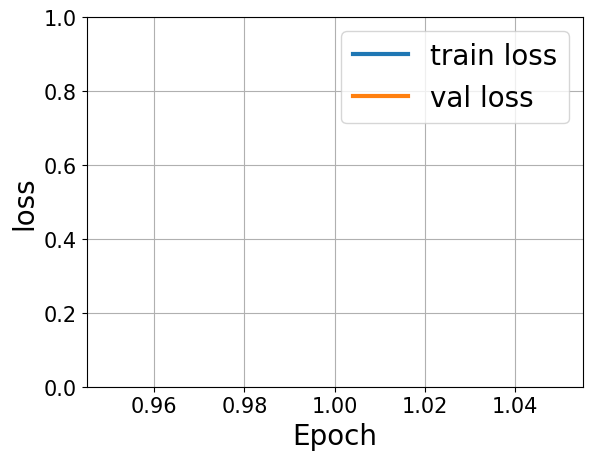

In [ ]:
plt.figure()
plt.plot(range(1,num_epochs+1), loss_history, label = "train loss", linewidth=3)
plt.plot(range(1,num_epochs+1), val_loss_history, label = "val loss", linewidth=3)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 1)
plt.grid()

* __packed padding__: ok
    - resolving unreasonable overshooting
    - resolving the issue of zero padding and not knowing the original length
* __batch normalization__
    - so far overshooting
* __learning rate__
    - a bit large (0.001 -> 0.005) works better
* __layer and hidden size__: ok
    - not too much large, but larger one works well
* last batch dropout
    - works okay
* __gradient clipping__
* __gradient scheduler for decay__
* __dropout__: ok 

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    # correct_r = 0

    for batch_sequences, batch_labels in test_loader:
        # Data pre-processing
        lengths = torch.sum(batch_sequences.sum(dim=2) != 0, dim=1)
        batch_sequences = batch_sequences.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        output = model(batch_sequences, lengths)
        total += batch_labels.size(0)      

        print("output {}".format(output))

        ### prediction
        if binary_classification:
            pred = torch.round(output.squeeze())  # rounds to the nearest integer
            correct_tensor = pred.eq(batch_labels.float().view_as(pred))

        else: 
            _, pred = torch.max(output, 1) # multi classifier
            correct_tensor = pred.eq(batch_labels.long().view_as(pred))
        
        # correct_tensor = pred.eq(batch_labels.float().view_as(pred))
        current_correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        correct += np.sum(current_correct)

        if current_correct.any() == 1:
            print("pred {}".format(pred))
            print("here R correct {}".format(current_correct))
            print("labels {}".format(batch_labels.float()))
        
        y_true.extend(batch_labels.tolist())
        y_pred.extend(pred.tolist())

    print('Test Accuracy of the model on the test data: {} %'.format(100 * correct / total))

# Calculate other evaluation metrics (precision, recall, F1-score)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

output tensor([[0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018],
        [0.1018]], device='cuda:0')
pred tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
here R correct [ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True  True  True  True  True  True]
labels tensor([0., 0.

/home/mingi/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# https://discuss.pytorch.org/t/how-to-use-lstm-for-a-time-series-classification-task/130559/4
# https://notebook.community/Diyago/Machine-Learning-scripts/NLP/LSTM%20RNN/Sentiment%20pytorch/Sentiment_RNN

### Data input and output setup aimed for ROS topic

In [ ]:
def final_test(final_test_file_idx):
    # 1) data loading
    unpickled_df = pd.read_pickle("./dk_csv_20180101/binary/aisdk_20180101_{}.pkl".format(str(final_test_file_idx)))
    

    # 2) data pre-processing
    # 2-1) data preparation
    unpickled_df['heading_converted']  = np.deg2rad(unpickled_df['Heading'])
    # lambda function method: very fast! 
    # https://stackoverflow.com/questions/71249186/applying-function-to-column-in-a-dataframe

    # TODO from ROS no need to conversion of NED to Robotic? 
    unpickled_df['heading_converted'] = unpickled_df['heading_converted'].apply(convert_from_NED_to_Robotic)
    obj_id = unpickled_df['obj_index']

    # crop before passing
    crop_unpickled_df = get_trajectory_before_pass(unpickled_df, [obj_id[0]])
    # print(crop_unpickled_df)

    features = crop_unpickled_df[columns_for_x].values.tolist()
    label = 0 if crop_unpickled_df[columns_for_y].values[-1][0] == "L" else 1 # last row, only char

    print(np.shape([features]))
    print("label {}".format(label))

    # 2-2) data padding
    # or should we use [] for batch
    pad_feature = pad_sequence([torch.tensor(features)], batch_first=True)
    # pad_feature = pad_sequence(torch.tensor(features), batch_first=True)
    print(np.shape(pad_feature))

    # lengths = torch.sum(pad_feature.sum(dim=2) != 0, dim=1)
    # print(lengths)

    # prediction
    predict(model, pad_feature)

In [ ]:
# Test the model
def predict(model, streaming_input, sequence_length=None):
    """
    Args:
        - streaming_input: (torch.tensor) [B, L, F]: batch, length, feature_size as padded feature
    """

    # TODO use sequence length later for fixed data streaming length

    model.eval()
    with torch.no_grad():  
        # Data pre-processing
        lengths = torch.sum(streaming_input.sum(dim=2) != 0, dim=1)
        streaming_sequences = streaming_input.to(device)
        # batch_labels = streaming_input.to(device)

        # Forward pass
        output = model(batch_sequences, lengths)     

        ### prediction
        # TODO how to output probability
        print("------------ result ------------")
        if binary_classification:
            print("before round {}".format(output))
            pred = torch.round(output.squeeze())  # rounds to the nearest integer
            
            print("prdiction value {}".format(pred))
        else: 
            _, pred = torch.max(output, 1) # multi classifier
            correct_tensor = pred.eq(batch_labels.long().view_as(pred))


        if (pred.item() == 0):
            print("obstacle is L passing")
        else:
            print("obstacls is R passing")

In [ ]:
final_test_file_idx = 300
final_test(final_test_file_idx)

(1, 68, 5)
label 1
torch.Size([1, 68, 5])
------------ result ------------
before round tensor([[0.1018]], device='cuda:0')
prdiction value 0.0
obstacle is L passing


### Multi class trial

In [ ]:
"""
if not binary_classification:
    # Training loop
    model.train()
    loss_history =torch.tensor([])
    val_loss_history =torch.tensor([])

    for epoch in range(num_epochs):
        ##################################################################
        ##### training 
        ##################################################################
        for batch_sequences, batch_labels in train_loader:
            optimizer.zero_grad()

            # 1) Calculate the sequence lengths for the current batch
            lengths = torch.sum(batch_sequences.sum(dim=2) != 0, dim=1)

            batch_sequences = batch_sequences.to(device)
            batch_labels = batch_labels.to(device)
            
            # 2) Forward pass
            output = model(batch_sequences, lengths)
            
            # this is possible, but I did instead output squeeze to match dimension
            # batch_labels = torch.unsqueeze(batch_labels, 1)

            # 3) Compute the loss       
            # loss = criterion(output.squeeze(), batch_labels.float()) # MJ 2023.07.31
            loss = criterion(output.squeeze(), batch_labels.long())

            # 4) Backward pass and optimization
            loss.backward()
            
            # 5) Gradient Clipping
            # 5-1) Gradient Norm Clipping
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            # 5-2) Gradient Value Clipping
            # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        
            optimizer.step()

        loss_history = torch.cat([loss_history, torch.tensor([loss.item()]).float()], dim=0)

        # Print the loss for every epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}")

        ##################################################################
        ##### Validation
        ##################################################################
        # val_steps = 0
        # total_val = 0
        # correct_val = 0
        # for i, data in enumerate(val_loader, 0):
        #     with torch.no_grad():
        #         batch_sequences_val, batch_labels_val = data

        #         # 1) Calculate the sequence lengths for the current batch
        #         lengths_val = torch.sum(batch_sequences_val.sum(dim=2) != 0, dim=1)
        #         batch_sequences_val = batch_sequences_val.to(device)
        #         batch_labels_val = batch_labels_val.to(device)

        #         # 2) Forward pass
        #         output_val = model(batch_sequences_val, lengths_val)
        #         total_val += batch_labels_val.size(0)      

        #         ### prediction
                # if binary_classification:
                #     pred = torch.round(output.squeeze())  # rounds to the nearest integer
                # else: 
                #     _, pred = torch.max(output, 1) # multi classifier
                
        #         # correct_tensor_val = pred_val.eq(batch_labels_val.float().view_as(pred_val))
        #         correct_tensor_val = pred_val.eq(batch_labels_val.long().view_as(pred_val)) # MJ
        #         current_correct_val = np.squeeze(correct_tensor_val.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor_val.cpu().numpy())
        #         correct_val += np.sum(current_correct_val)

        #         # loss_val = criterion(output_val.squeeze(), batch_labels_val.float())
        #         loss_val = criterion(output_val.squeeze(), batch_labels_val.long())
        #         val_steps += 1

        # val_loss_history = torch.cat([val_loss_history, torch.tensor([loss_val.item()]).float()], dim=0)
        # print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {loss_val.item()}")

        
        ##################################################################
        ##### scheduler
        ##################################################################
        scheduler.step()

    print("Finished Training")
"""

'\nif not binary_classification:\n    # Training loop\n    model.train()\n    loss_history =torch.tensor([])\n    val_loss_history =torch.tensor([])\n\n    for epoch in range(num_epochs):\n        ##################################################################\n        ##### training \n        ##################################################################\n        for batch_sequences, batch_labels in train_loader:\n            optimizer.zero_grad()\n\n            # 1) Calculate the sequence lengths for the current batch\n            lengths = torch.sum(batch_sequences.sum(dim=2) != 0, dim=1)\n\n            batch_sequences = batch_sequences.to(device)\n            batch_labels = batch_labels.to(device)\n            \n            # 2) Forward pass\n            output = model(batch_sequences, lengths)\n            \n            # this is possible, but I did instead output squeeze to match dimension\n            # batch_labels = torch.unsqueeze(batch_labels, 1)\n\n            # 3) C